# Problem Set 2

A detailled PDF report named $\verb|reportPB2.pdf|$ is available at the root of the repository. That report explains the results obtained from the code base below.

In [1]:
%reset -f

In [2]:
import numpy as np
import numpy.linalg as npalg

import scipy as sp
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import loadmat
from scipy.linalg import orth
from scipy.linalg import eigh

from time import process_time

import matplotlib.tri as tri
import matplotlib.pyplot as plt

from IPython.display import Image

In [3]:
## Gloabl parameters in this notebook (unless otherwise specified)
GlobalParams = {}
GlobalParams["tuning"] = "coarse"
print(GlobalParams)

{'tuning': 'coarse'}


## Load and plot the grids

In [577]:
grids = loadmat('FE_grid.mat',simplify_cells=True)
# grids = loadmat('FE_grid.mat')###
print(grids.keys())
## My chose the global parameter to use
tuning = GlobalParams["tuning"]
grid = grids['FE_grid'][tuning]
# show the keys in the grid
print(grid.keys())
print("number of nodes:",grid['nodes'])
print("number of elements:",grid['elements'])
x=grid['coor'][:,0]
y=grid['coor'][:,1]
z=np.sin(np.pi*x)*np.cos(np.pi*y)
# be careful  the indices must start at 0, in mat files they start at one, so substract 1
triangles=np.concatenate(grid['theta'][0:5]-1)       ## coarse_grid['theta'] is a list of arrays
T=tri.Triangulation(x,y,triangles)          # pour chque éléments, onna les identifiants de ses trois points, dans le sens contraire des aiguilles dune montre
# print(T.neighbors)

dict_keys(['__header__', '__version__', '__globals__', 'FE_grid'])
dict_keys(['nodes', 'coor', 'elements', 'theta'])
number of nodes: 1333
number of elements: 2095


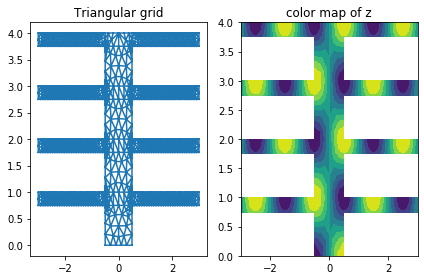

In [578]:
def plot(mesh,u):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs = axs.flatten()

    # Plot the triangulation.
    axs[0].triplot(mesh)
    axs[0].set_title('Triangular grid')

    # Plot the color map.
    axs[1].tricontourf(mesh,u)          # on peut aussi faire un tricontrour pour afficher les lignes de niveau
    axs[1].set_title('color map of z')
    fig.tight_layout()
    plt.show()
plot(T,z)

## Load the matrices

In [579]:
M = loadmat('FE_matrix.mat',simplify_cells=True)
tuning = GlobalParams["tuning"]
Ahq = M['FE_matrix'][tuning]['Ahq']       ## On les appelle _coarse parcequ'on a un choisi plus haut un maillage grossier. On pourrait le remlacer par grid_level
Fh = M['FE_matrix'][tuning]['Fh']

## Solve the finite element problem

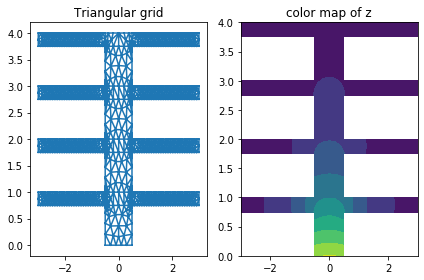

In [580]:
def assembleA(mu,Aq):
    A = csc_matrix(Aq[0].shape)
    for k in range(0,6):
        A += mu[k]*Aq[k]
    return A

k_i=1
Bi=0.1
mu=np.array([k_i,k_i, k_i, k_i, 1, Bi])
Ah = assembleA(mu,Ahq)
u = spsolve(Ah, Fh)
plot(T,u)

## Question b)

### Subquestion 1.

In [581]:
## Utility function
def loadFEMatrix(tuning):
    M = loadmat('FE_matrix.mat',simplify_cells=True)
    Ahq = M['FE_matrix'][tuning]['Ahq']
    Fh = M['FE_matrix'][tuning]['Fh']
    return Ahq, Fh

In [582]:
## Utility functions

def loadSample(sample):
    return loadmat('RB_sample.mat',simplify_cells=True)["RB_sample"][sample]

## X-inner product
def buildMuBar():
    return np.array([1, 1, 1, 1, 1, 0.1])

def buildMu(ki,Bi,case):
    if case == "sample1":
        assert (ki >= 0.1 and ki <=10)
        return np.array([ki, ki, ki, ki, 1, 0.1])
    if case == "sample2":
        assert (Bi >=0.01 and Bi <=1)
        return np.array([0.4, 0.6, 0.8, 1.2, 1, Bi])
    if case == "sample3":
        assert (ki >= 0.1 and int(ki) <= 10)
        assert (Bi >=0.01 and Bi <= 1)
        return np.array([ki, ki, ki, ki, 1, Bi])

In [583]:
## Build the Z RB matrix
def buildZ(sample,Ahq,Fh,case,N):

    ## For question b)
    if case == "sample1":
        assert (N <= len(sample))
        Ncal = Ahq[0].shape[0]
        Z = np.zeros(shape=(Ncal,N))

        for j in range(N):
            k_i = sample[j]
            Bi = 0.1
            mu=np.array([k_i, k_i, k_i, k_i, 1, Bi])
            u = spsolve(assembleA(mu, Ahq), Fh)
            Z[:,j] = u

    ## For question c)
    if case == "sample2":
        assert (N <= len(sample))
        Ncal = Ahq[0].shape[0]
        Z = np.zeros(shape=(Ncal,N))

        for j in range(N):
            Bi = sample[j]
            mu = buildMu(None,Bi,"sample2")
            u = spsolve(assembleA(mu, Ahq), Fh)
            Z[:,j] = u

    ## For question d)
    if case == "sample3":
        carSample = list(zip(sample[0],sample[1]))
        assert (N <= len(carSample))

        Ncal = Ahq[0].shape[0]
        Z = np.zeros(shape=(Ncal,N))

        for j in range(N):
            ki, Bi = carSample[j]
            mu = buildMu(ki,Bi,"sample3")
            u = spsolve(assembleA(mu, Ahq), Fh)
            Z[:,j] = u

    return Z

In [584]:
## Global paremeters for question b) 
Ahq, Fh = loadFEMatrix("coarse")
muBar = buildMuBar()
AhqBar = assembleA(muBar, Ahq)  ## Always redefine this matrix
sample1 = loadSample("sample1")

In [585]:
## X-inner product using AhqBar
def inner(u,v):
    return u.T@AhqBar@v

## X-norm
def norm(u):
    return np.sqrt(inner(u,u))

## Project v on u using AhqBar inner product
def proj(v,u):
    return inner(u,v)*u / inner(u,u)

## Orthonormalisation
def orthonormalize(Z,mode):
    ## Scipy ortonomalisation
    if mode == "SP":
        return orth(Z)
    
    ## QR ortonomalisation
    if mode == "QR":
        return npalg.qr(Z)[0]

    ## Gram-Schidt ortonomalisation
    if mode == "GS":
        Zorth = np.zeros_like(Z)
        Zorth[:,0] = Z[:,0] / norm(Z[:,0])

        N = Z.shape[1]
        for j in range(1,N):
            xj = Z[:,j]
            for k in range(0,j):
                xj -= proj(Z[:,j],Zorth[:,k])
            Zorth[:,j] = xj / norm(xj)
        return Zorth

## Offline building of necessary RB components
def buildOfflineAFL(Z,Ahq,Fh):
    Anq = []
    for q in range(0,6):
        Anq.append(csc_matrix(Z.T@Ahq[q]@Z))
    
    Fn = Z.T@Fh
    Ln = Z.T@Fh

    return Anq, Fn, Ln  ## A_N^q, F_N, and L_N

In [586]:
## Simple Test 
# print("Sample 1:", sample1)
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# Z = buildZ(sample1, Ahq, Fh, "sample1", N=8)
# print(Z)
# Zorth = orthonormalize(Z,"GS")
# print(inner(Zorth, Zorth))  ## Z is orthonormal

In [587]:
## Comparing condition numbers
Z = buildZ(sample1, Ahq, Fh, "sample1", N=8)
Zorth = orthonormalize(Z,"GS")

## A quick function to compute conditioning
def assembleAndComputeCond(Z,mu,Ahq,Fh):
    Anq, Fn, Ln = buildOfflineAFL(Z,Ahq,Fh)
    An = assembleA(mu,Anq)
    return  npalg.cond(An.todense())

## Compute continuity and coercity constants by solving a generalized eigen value problem
def assembleAndComputeConstants(mu,Ahq,AhqBar):
    Ah = assembleA(mu,Ahq)
    valP, vecP = eigh(Ah.todense(), AhqBar.todense(), eigvals_only=False)
    valP = np.sort(np.real(valP))
    alpha = np.min(valP)
    gamma = np.max(np.abs(valP))    ## Lipschitz continuity constant
    return gamma/alpha

print("mu = 1")
mu = buildMu(1,0.1,"sample1")
cond = assembleAndComputeCond(Z,mu,Ahq,Fh)
gammaAlpha = assembleAndComputeConstants(mu,Ahq,AhqBar)
print("Condition number without normalization: ", cond)

cond = assembleAndComputeCond(Zorth,mu,Ahq,Fh)
gammaAlpha = assembleAndComputeConstants(mu,Ahq,AhqBar)
print("Condition number with G-S normalization: ", cond)
print("Gamma / alpha: ", gammaAlpha)

print()
print("mu = 10")
mu = buildMu(10,0.1,"sample1")
cond = assembleAndComputeCond(Z,mu,Ahq,Fh)
gammaAlpha = assembleAndComputeConstants(mu,Ahq,AhqBar)
print("Condition number without normalization: ", cond)

cond = assembleAndComputeCond(Zorth,mu,Ahq,Fh)
gammaAlpha = assembleAndComputeConstants(mu,Ahq,AhqBar)
print("Condition number with G-S normalization: ", cond)
print("Gamma / alpha: ", gammaAlpha)

mu = 1
Condition number without normalization:  33575189921.599743
Condition number with G-S normalization:  1.0000000000959741
Gamma / alpha:  1.0000000000000868

mu = 10
Condition number without normalization:  23018985185.011765
Condition number with G-S normalization:  9.92860581424881
Gamma / alpha:  10.000000000000359


In [588]:
## Solves the problem in FE space
def solveFE(mu, Ahq, Fh):
    Ah = assembleA(mu,Ahq)
    u = spsolve(Ah, Fh)
    return u

## Solves the problem in RB space
def solveRB(mu, Anq, Fn):
    An = assembleA(mu,Anq)
    un = spsolve(An, Fn)
    return un

## Solve the reduced basis approximation without gram-schmidt
print("WITHOUT ORTHONORMALISATION")

Ahq, Fh = loadFEMatrix("coarse")
Z = buildZ(sample1, Ahq, Fh, "sample1", N=8)
Anq, Fn, Ln = buildOfflineAFL(Z,Ahq,Fh)

mu1 = buildMu(0.1,0.1,"sample1")        ## Used to build Z
un = solveRB(mu1, Anq, Fn)
print("Solution with mu_1: \n", un)

print()

mu2 = buildMu(10,0.1,"sample1")          ## Used to build Z
un = solveRB(mu2, Anq, Fn)
print("Solution with mu_2: \n", un)

print()

mu3 = buildMu(1.0975,0.1,"sample1")       ## Used to build Z
un = solveRB(mu3, Anq, Fn)
print("Solution with mu_3: \n", un)

print()

## Solve the reduced basis approximation with gram-schmidt
print("WITH ORTHONORMALISATION")
Zorth = orthonormalize(Z, "GS")
Anq, Fn, Ln = buildOfflineAFL(Zorth,Ahq,Fh)

un = solveRB(mu1, Anq, Fn)
print("Solution with mu_1: \n", un)

print()

un = solveRB(mu2, Anq, Fn)
print("Solution with mu_2: \n", un)

print()

un = solveRB(mu3, Anq, Fn)
print("Solution with mu_3: \n", un)

WITHOUT ORTHONORMALISATION
Solution with mu_1: 
 [ 9.99961883e-01  8.96197661e-07  1.39699761e-05 -2.81270645e-06
 -6.00133918e-05 -3.33987867e-06  2.49361990e-06  8.69227757e-05]

Solution with mu_2: 
 [-3.08738447e-06  1.00000012e+00  1.22928595e-06 -3.72331933e-07
 -4.99830853e-06 -3.26125605e-07  3.12180728e-07  7.11788170e-06]

Solution with mu_3: 
 [ 2.05515923  0.28776033 -1.32618596 -1.15988148  3.90438429  0.70153475
  1.58086871 -5.04363985]

WITH ORTHONORMALISATION
Solution with mu_1: 
 [ 1.91716756e+00 -7.69467736e-16 -4.59178056e-15 -3.59169340e-17
 -1.07436445e-15 -1.43136679e-15  1.04173890e-15  6.31908135e-17]

Solution with mu_2: 
 [ 7.38758647e-01  8.77362719e-01  1.55121705e-15  1.00119891e-15
 -5.06601422e-17 -5.64256378e-16 -6.66879634e-16 -5.10678428e-16]

Solution with mu_3: 
 [ 1.03354441e+00  6.71854817e-01  2.04094195e-01  6.23943023e-02
 -9.38130901e-03  4.11523338e-03  5.73808317e-04 -5.27702150e-05]


### Subquestion 2.

In [589]:
Anq, Fn, Ln = buildOfflineAFL(Zorth, Ahq, Fh)

mu = buildMu(1.5,0.1,"sample1")

un = solveRB(mu, Anq, Fn)
output = Ln.T@un
print("Output on Gamma_root: ", output)

Output on Gamma_root:  1.531074970789645


### Subquestion 3.

In [590]:
## Redefine paremeters for what follows
sample1 = loadSample("sample1")
Ahq, Fh = loadFEMatrix("coarse")    ## CHANGE HERE to "medium" or "fine" FOR Subquestion 6.!!
muBar = buildMuBar()
AhqBar = assembleA(muBar, Ahq)

In [591]:
ntest = 100
sample = np.linspace(0.1, 10, 100)

Nmax = 8
energyRelNorm = np.zeros(shape=(Nmax-1,ntest))
outputRelNorm = np.zeros(shape=(Nmax-1,ntest))

FETimes = np.zeros(shape=(Nmax-1,ntest))
RBTimes = np.zeros(shape=(Nmax-1,ntest))
nbTimeIter = 5 ## number of iterations for time average

for N in range(2,Nmax+1):
    Z = buildZ(sample1, Ahq, Fh, "sample1", N)
    Zorth = orthonormalize(Z, "GS")
    Anq,Fn,Ln = buildOfflineAFL(Zorth,Ahq,Fh)

    for k in range(ntest):
        mu = buildMu(sample[k], 0.1, "sample1")

        ## Solve FE problem
        tot_time = 0.
        for _ in range(nbTimeIter):
            start = process_time()                  ##----
            u = solveFE(mu,Ahq,Fh)
            Troot = Fh.T@u
            tot_time += process_time() - start ##----
        FETimes[N-2,k] = tot_time/nbTimeIter

        ## solve RB prboblem
        tot_time = 0.
        for _ in range(nbTimeIter):
            start = process_time()                  ##----
            un = solveRB(mu, Anq, Fn)
            Trootn = Ln.T@un
            tot_time += process_time() - start ##----
        RBTimes[N-2,k] = tot_time/nbTimeIter

        ## Convert RB sol into FE space
        un = Z@un

        ## Compute errors
        energyRelNorm[N-2,k] = norm(u-un)/norm(u)
        outputRelNorm[N-2,k] = abs(Troot-Trootn)/abs(Troot)

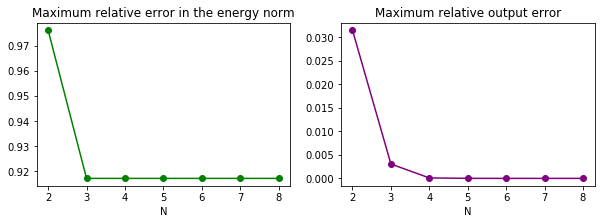

In [592]:
N = np.arange(2,Nmax+1)
energyPlot = np.max(energyRelNorm, axis=1)
outputPlot = np.max(outputRelNorm, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax[0].plot(N, energyPlot,'o-', color='g')
ax[0].set_xlabel("N")
ax[0].set_title("Maximum relative error in the energy norm")

ax[1].plot(N, outputPlot,'o-',  color='purple')
ax[1].set_xlabel("N")
ax[1].set_title("Maximum relative output error")

plt.savefig("tex/img/sample1Error.png")

Now let's compare the convergence in energy norm when the matrix Z is (or not) orthonormalized.

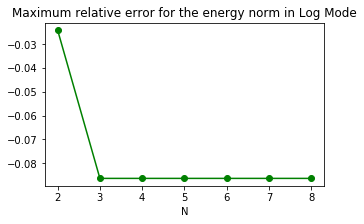

In [593]:
N = np.arange(2,Nmax+1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
ax.plot(N, np.log(energyPlot),'o-', color='g')
ax.set_xlabel("N")
ax.set_title("Maximum relative error for the energy norm in Log Mode")

## Z is othonormalized
plt.savefig("tex/img/sample1ErrorLogOrth.png")

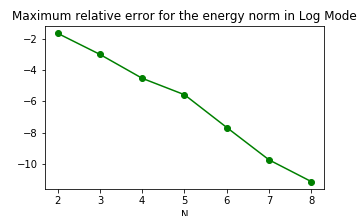

In [594]:
## Z is not othonormalized
Image("tex/img/sample1ErrorLog.png")

We can see a much faster convergence (as a lower error) when the matrix Z is orthonormalized. 

### Subquestion 4.

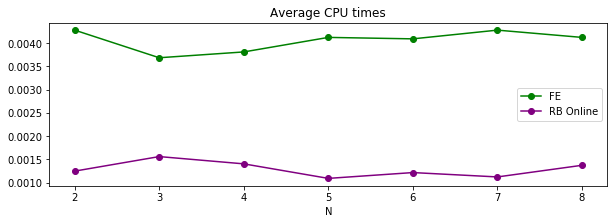

In [595]:
N = np.arange(2,Nmax+1)
FETimesPlot = np.mean(FETimes, axis=1)
RBTimesPlot = np.mean(RBTimes, axis=1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,3))
ax.plot(N, FETimesPlot,'o-', color='g', label="FE")
ax.plot(N, RBTimesPlot,'o-', color='purple', label="RB Online")
ax.set_xlabel("N")
ax.set_title("Average CPU times")
plt.legend()

plt.savefig("tex/img/sample1Time.png")

### Subquestion 5.

In [596]:
## A list to hold the accuracies in the sample
accList = np.zeros(shape=(ntest))
acc = 100

N = 1

while acc > 1. and N < Nmax+1:
    N += 1

    Z = buildZ(sample1, Ahq, Fh, "sample1", N)
    Zorth = orthonormalize(Z, "GS")
    Anq,Fn,Ln = buildOfflineAFL(Zorth,Ahq,Fh)

    for k in range(ntest):
        mu = buildMu(sample[k], 0.1, "sample1")

        u = solveFE(mu,Ahq,Fh)
        Troot = Fh.T@u

        un = solveRB(mu, Anq, Fn)
        Trootn = Ln.T@un

        accList[k] = abs(Troot-Trootn) * 100 / abs(Troot)

    acc = np.max(accList)

timeSaving = np.mean(FETimes[N-2]-RBTimes[N-2])

print("Achieved accuracy:", acc)
print("Required N:", N)
print("CPU time savings:", timeSaving, "sec")

Achieved accuracy: 0.3056515255907647
Required N: 3
CPU time savings: 0.0021249999999999997 sec


### Subquestion 6.

- Go back to subquestion 3.
- Change the triangulation to `medium` or `fine`
- Run from there and see the the results

The pictures have been saved and are presented below.

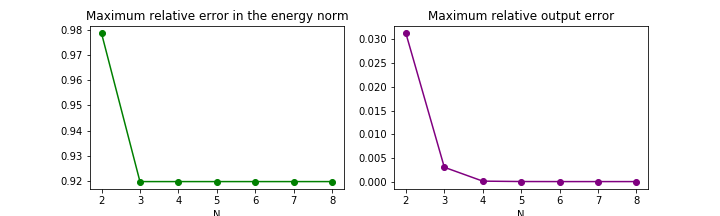

In [597]:
## Medium triangulation
Image("tex/img/sample1ErrorMedium.png")

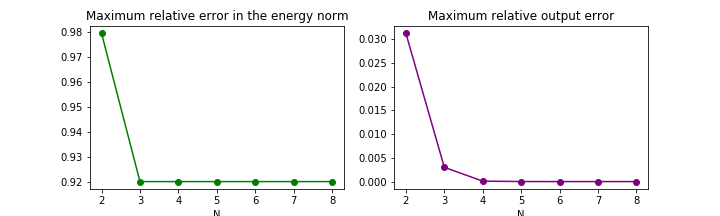

In [598]:
## Fine triangulation
Image("tex/img/sample1ErrorFine.png")

We can see that errors (in the RB basis) do not depend on the triangulation. As for the time, let's observe the comparison belows.

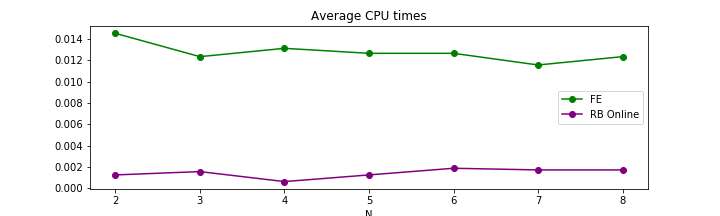

In [599]:
## Medium triangulation
Image("tex/img/sample1TimeMedium.png")

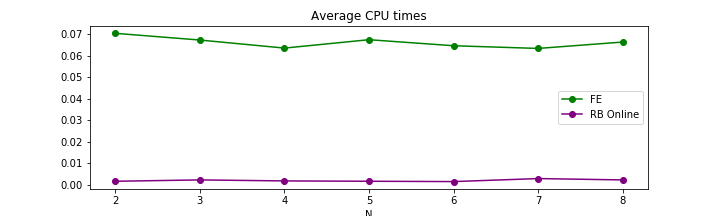

In [600]:
## Fine triangulation
Image("tex/img/sample1TimeFine.png")

As expected, the finer the triangulation, the longuer it takes for the FE computation to be completed. The online stage for the RB computation however, demands a relatively constant and insignificant time. 

## Question c)

### Subquestion 1.
Generate the sample set

In [601]:
## Redefine global paremeters for what follows
sample2 = loadSample("sample2")
Ahq, Fh = loadFEMatrix("medium")
muBar = buildMuBar()
AhqBar = assembleA(muBar, Ahq)

In [602]:
Z = buildZ(sample2, Ahq, Fh, "sample2", N=11)
Zorth = orthonormalize(Z, "GS")
Anq,Fn,Ln = buildOfflineAFL(Zorth,Ahq,Fh)

mu0 = buildMu(None,0.15,"sample2")
un = solveRB(mu0, Anq, Fn)
output = Ln.T@un
print("Output on Gamma_root: ", output)

Output on Gamma_root:  1.5156084809573889


### Subquestion 2.

In [603]:
ntest = 100
sample = np.linspace(0.01, 1, 100)

Nmax = 11
energyRelNorm = np.zeros(shape=(Nmax-1,ntest))
outputRelNorm = np.zeros(shape=(Nmax-1,ntest))

for N in range(2,Nmax+1):
    Z = buildZ(sample2, Ahq, Fh, "sample2", N)
    Zorth = orthonormalize(Z, "GS")
    Anq,Fn,Ln = buildOfflineAFL(Zorth,Ahq,Fh)

    for k in range(ntest):
        mu = buildMu(None, sample[k], "sample2")

        ## Solve FE problem
        u = solveFE(mu,Ahq,Fh)
        Troot = Fh.T@u

        ## solve RB prboblem
        un = solveRB(mu, Anq, Fn)
        Trootn = Ln.T@un

        ## Convert RB sol into FE space
        un = Z@un

        ## Compute errors
        energyRelNorm[N-2,k] = norm(u-un)/norm(u)
        outputRelNorm[N-2,k] = abs(Troot-Trootn)/abs(Troot)

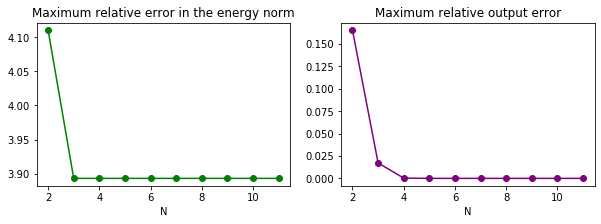

In [604]:
N = np.arange(2,Nmax+1)
energyPlot = np.max(energyRelNorm, axis=1)
outputPlot = np.max(outputRelNorm, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax[0].plot(N, energyPlot,'o-', color='g')
ax[0].set_xlabel("N")
ax[0].set_title("Maximum relative error in the energy norm")

ax[1].plot(N, outputPlot,'o-',  color='purple')
ax[1].set_xlabel("N")
ax[1].set_title("Maximum relative output error")

plt.savefig("tex/img/sample2Error.png")

### Subquestion 3.

In [605]:
def cost(Bi): ## N = Nmax = 11
    mu = buildMu(None,Bi,"sample2")
    un = solveRB(mu, Anq, Fn)
    return Bi + Ln.T@un

left = 0.01
right = 1.

costLTmp = cost(left)
costRTmp = cost(right)

nbiter = 0

while(abs(costRTmp-costLTmp) >= 1e-16 and nbiter<=500):
    leftTmp = left + (right-left)/3.
    rightTmp = left + 2*(right-left)/3.

    costLTmp = cost(leftTmp)
    costRTmp = cost(rightTmp)

    if costLTmp < costRTmp:
        right = rightTmp
    elif costLTmp > costRTmp:
        left = leftTmp
    else:
        left = leftTmp
        right = rightTmp

    nbiter+=1

print("Number of iterations:", nbiter)
center = (left+right)/2.
print("Optimal Bi number:", center)
print("Optimal cost:", cost(center))

Number of iterations: 42
Optimal Bi number: 0.4029526594948012
Optimal cost: 1.465506870498294


## Question d)

### Subquestion 1.

In [606]:
## Redefine global paremeters for what follows
sample3 = loadSample("sample3")
Ahq, Fh = loadFEMatrix("coarse")
muBar = buildMuBar()
AhqBar = assembleA(muBar, Ahq)

In [607]:
Z = buildZ(sample3, Ahq, Fh, "sample3", N=46)
Zorth = orthonormalize(Z, "GS")
Anq,Fn,Ln = buildOfflineAFL(Zorth,Ahq,Fh)

In [608]:
ntest = 400
sampleki = np.linspace(0.1, 10, 20)
sampleBi = np.linspace(0.01, 1, 20)

## Build the sample set of size 400
sample = []
for i in range(20):
    for j in range(20):
        sample.append((sampleki[i], sampleBi[j]))

Nmax = 46
energyRelNorm = np.zeros(shape=(Nmax-1,ntest))
outputRelNorm = np.zeros(shape=(Nmax-1,ntest))

for N in range(2,Nmax+1):
    Z = buildZ(sample3, Ahq, Fh, "sample3", N)
    Zorth = orthonormalize(Z, "GS")
    Anq,Fn,Ln = buildOfflineAFL(Zorth,Ahq,Fh)

    for k in range(ntest):
        ki, Bi = sample[k]
        mu = buildMu(ki, Bi, "sample3")

        ## Solve FE problem
        u = solveFE(mu,Ahq,Fh)
        Troot = Fh.T@u

        ## solve RB prboblem
        un = solveRB(mu, Anq, Fn)
        Trootn = Ln.T@un

        ## Convert RB sol into FE space
        un = Z@un

        ## Compute errors
        energyRelNorm[N-2,k] = norm(u-un)/norm(u)
        outputRelNorm[N-2,k] = abs(Troot-Trootn)/abs(Troot)

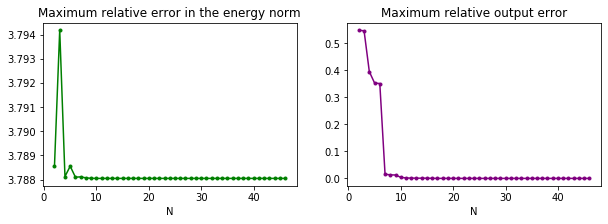

In [609]:
N = np.arange(2,Nmax+1)
energyPlot = np.max(energyRelNorm, axis=1)
outputPlot = np.max(outputRelNorm, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax[0].plot(N, energyPlot,'.-', color='g')
ax[0].set_xlabel("N")
ax[0].set_title("Maximum relative error in the energy norm")

ax[1].plot(N, outputPlot,'.-',  color='purple')
ax[1].set_xlabel("N")
ax[1].set_title("Maximum relative output error")

plt.savefig("tex/img/sample3Error.png")